# Multi cut 策略求解两阶段随机规划
Single cut每次将各个场景聚合形成一个最优割，损失了部分信息。Multi cut 则为每个场景单独添加最优割，从而减少迭代次数，但同时会增大主问题规模。

Multi cut 为每个场景生成一个松弛变量，最优割变为
$$
\mathbf{\beta_s}^{\mathrm{T}}\mathbf{x}+\eta_s \geq \beta_{0s}, \quad \forall s=1,2,\ldots,S
$$

In [2]:
using JuMP, Gurobi
import MathOptInterface as MOI
# parameters
# first stage
const c=[50,30,15,10]
const A=[-1 0 0 0;0 -1 0 0;0 0 -1 0;0 0 0 -1;0 -1 -1 -1]
const b=[-300,-700,-600,-500,-1600]
# second stage
const S=5
const p=[0.15,0.3,0.3,0.2,0.05]
const q=[-1150,-1525,-1900]
const W=[-6 -8 -10;-20 -25 -28;-12 -15 -18;-8 -10 -14;-1 0 0;0 -1 0;0 0 -1]
const T=[1 0 0 0;0 1 0 0;0 0 1 0;0 0 0 1;0 0 0 0;0 0 0 0;0 0 0 0]
const r1=[0,0,0,0,-15,-10,-5]
const r2=[0,0,0,0,-25,-20,-15]
const r3=[0,0,0,0,-25,-20,-25]
const r4=[0,0,0,0,-30,-25,-30]
const r5=[0,0,0,0,-10,-10,-10]
const r=[r1,r2,r3,r4,r5]
const max_iter=50

50

In [3]:
function add_multi_cut!(MP::Model)
    is_opt=0
    x_value=value.(MP[:x])
    η_value=value.(MP[:η])
    obj=0
    for s in 1:S
        β=zeros((4,))
        β0=0
        SP=Model(Gurobi.Optimizer)
        set_silent(SP)
        set_attribute(SP,"DualReductions",0)
        set_attribute(SP,"InfUnbdInfo",1)
        @variable(SP,y[1:3]>=0)
        @objective(SP,Min, q'*y)
        @constraint(SP,cons, W*y.>=r[s]-T*x_value)
        optimize!(SP)
        if termination_status(SP)!=MOI.OPTIMAL
            println("Subproblem $s is infeasible, adding feasibility cut")
            unbd_ray=dual.(cons)
            β=vec(unbd_ray'*T)
            β0=unbd_ray'*r[s]
            @constraint(MP, β'*x>= β0)
            return (is_opt=1,uk=obj)
        else
            obj+=p[s]*objective_value(SP)
            duals=dual.(cons)
            β=vec(p[s]*duals'*T)
            β0=p[s]*duals'*r[s]
            if η_value[s]<β0-β'*x_value-1e-4
                is_opt=2
                println("Subproblem $s optimality cut violated, adding optimality cut")
                @constraint(MP, β'*x+η[s]>= β0)
            end
        end
    end
    obj+=c'*x_value
    return (is_opt=is_opt,uk=obj)
end

add_multi_cut! (generic function with 1 method)

In [4]:
k=0
u_history=[]
u_k=Inf

Inf

In [5]:
MP=Model(Gurobi.Optimizer)
set_silent(MP)
@variable(MP, x[1:4]>=0)
@variable(MP,η[1:S])
@objective(MP,Min, c'*x+sum(η))
@constraint(MP,A*x.>=b)
@constraint(MP,η.>=-1e6) #初始松弛变量下界，否则问题无界
optimize!(MP)

Set parameter LicenseID to value 2632898


In [6]:
result=add_multi_cut!(MP)
while result.is_opt!=0 && k<max_iter
    k+=1
    if result.is_opt==2
      global u_k=result.uk
    end
    push!(u_history,u_k)
    println("Iteration $k: Objective value = $u_k, Optimality status = $(result.is_opt)")
    optimize!(MP)
    global result=add_multi_cut!(MP)
end

Set parameter LicenseID to value 2632898
Subproblem 1 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 2 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 3 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 4 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 5 optimality cut violated, adding optimality cut
Iteration 1: Objective value = 0.0, Optimality status = 2
Set parameter LicenseID to value 2632898
Subproblem 1 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 2 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 3 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 2632898
Subproblem 4 optimality cut violated, adding optimality cut
Set parameter LicenseID to value 

In [7]:
optimize!(MP)
println("Optimal first-stage decision: x = ", value.(MP[:x]))
println("Optimal objective value: ", objective_value(MP))

Optimal first-stage decision: x = [236.40000000000006, 690.0, 432.00000000000017, 318.00000000000017]
Optimal objective value: -2268.5


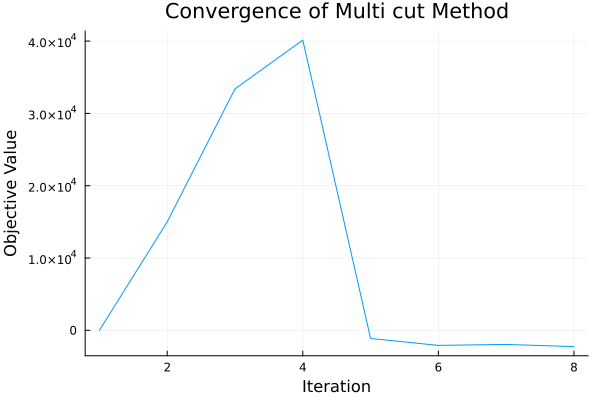

In [8]:
using Plots
plot(1:length(u_history),u_history, xlabel="Iteration", ylabel="Objective Value", title="Convergence of Multi cut Method", legend=false)

值得注意的是，Multi cut 方法下仅进行了8次迭代，少于Single cut的19次